In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 29 19:02:51 2021

Recurrent series tutorial

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)


## Generate a time series
First we start by creating a time series we'll use as data

In [ ]:
def generate_time_series(batch_size, n_steps):
    """
    Generate a time series of length n_steps
    batch_size: number of examples to generate
    n_steps: length of time series
    """

    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", steps_ahead = 10):
    """
    Plot a time series
    series: series to plot
    y: the next time step to predict
    y_pred: the prediction
    """

    plt.plot(series, ".-")
    n_steps = len(series)

    if y is not None:
        plt.plot(range(n_steps, n_steps+ steps_ahead),  y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(range(n_steps, n_steps+ steps_ahead), y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)

    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + steps_ahead, -1, 1])

In [3]:
#We generate a time series, and split between training and testing
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)  #50 time steps of train data, plus 10 to predict
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:]


The figures below show the time series data we'll use, with the dotted points being the values we want to predict

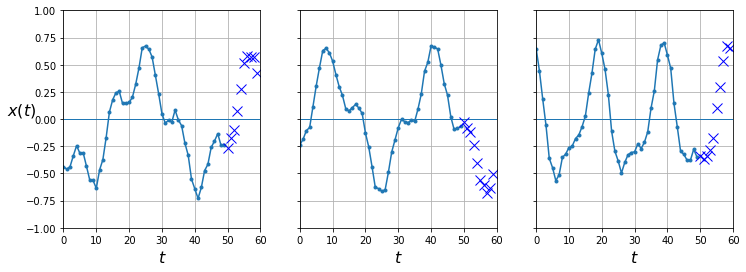

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, :, 0],
                y_label=("$x(t)$" if col==0 else None))
# save_fig("time_series_plot")
plt.show()

First let's try a simple dense network, no RNN yet

Epoch 1/20
219/219 [==============================] - 2s 4ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0496 - val_loss: 0.0425

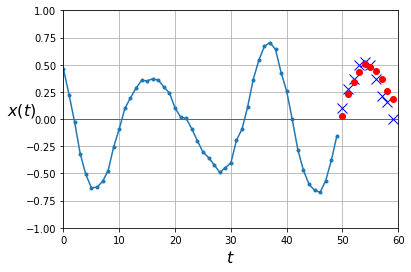

In [5]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model_base = keras.models.Sequential([
    keras.layers.InputLayer(X_train.shape[1:]),
    keras.layers.Flatten(),     #from [batch, time steps, 1] to [batch, time steps]
    keras.layers.Dense(10)
    ])


model_base.compile(loss = 'mse', optimizer = 'adam')

model_base.fit(X_train, y_train,
               epochs=20,
               validation_data=(X_valid, y_valid))

ypred = model_base.predict(X_test)

print( np.mean(keras.losses.mean_squared_error(y_test[:,:,0], ypred)) ) #0.019629803

plot_series(X_test[0, :, 0], y_test[0, :, 0], ypred[0 , :])

We observe that the dense network captures the trend of the time series, although the error
starts to grow in the last couple of points. Let's try next a LSTM with a dense layer as the last layer.

Epoch 1/20
219/219 [==============================] - 9s 19ms/step - loss: 0.0601 - val_loss: 0.0276

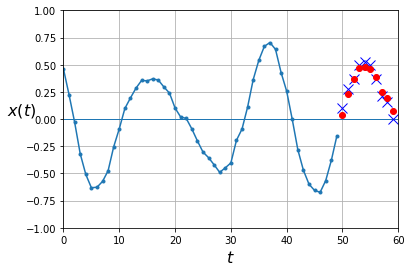

In [6]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape = [None, 1]),     #RNNs can process time series of any size
    keras.layers.LSTM(20, return_sequences=True),   #Return sequences so that the next LSTM layer can read the sequence too
    keras.layers.LSTM(20),
    keras.layers.Dense(10)
    ])


model.compile(loss = 'mse', optimizer = 'adam')

model.fit(X_train, y_train,
               epochs=20,
               validation_data=(X_valid, y_valid))

ypred = model.predict(X_test)

print( np.mean(keras.losses.mean_squared_error(y_test[:,:,0], ypred)) ) #0.00785493

plot_series(X_test[0, :, 0], y_test[0, :, 0], ypred[0 , :])

The MSE is smaller, indicating that the LSTM does learn better the patterns of the time series.
We reduced the MSE from 0.019 to 0.008 :)

In this model, each of the 10 neurons in the final layer predicts one of the 10 time steps in the test set.


How about if instead each neuron tried to predict a sequence? That is, a sequence-to-sequence model.

At each time step *kk*, the model will predict
steps *kk+1* to *kk+10*


In [7]:
# First, change the target. Instead of vector of size 10,
# a sequence of 10D vectors of length 50

# At each time step 'kk', the model will predict
# steps 'kk+1' to 'kk+10'

Y = np.empty(( 10000, n_steps, 10))

for kk in range(0, 10):
    Y[:,:, kk] = series[:, kk+1:kk+1+n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

print(X_train.shape)
print(Y_train.shape)


(7000, 50, 1)
(7000, 50, 10)


Epoch 1/20
219/219 [==============================] - 7s 18ms/step - loss: 0.0433 - last_time_step_mse: 0.0276 - val_loss: 0.0264 - val_last_time_step_mse: 0.0113

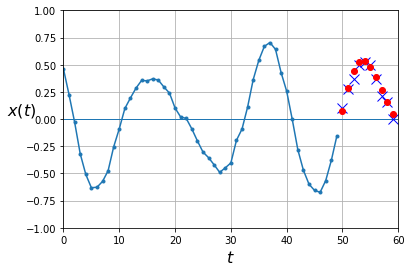

In [8]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
        keras.layers.LSTM(20, return_sequences=True, input_shape = [None,1]),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.TimeDistributed( keras.layers.Dense(10) )  #You can then use TimeDistributed to apply the same Conv2D layer to each of the 10 timesteps, independently
    ])

# We care about the error in the last value predicted in each time step
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train,
                    epochs=20,
                    validation_data=(X_valid, Y_valid))


Ypred = model.predict(X_test)
Ypred.shape

plot_series(X_test[0, :, 0], Y_test[0, -1], Ypred[0,-1])

print( np.mean(keras.losses.mean_squared_error(Y_test[0, -1], Ypred[0,-1]) ) ) #0.0012398281, much better!

Success! We reduced the MSE again, from 0.008 to 0.001 :)

